<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [19]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np

In [20]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

In [127]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])



cond_on         = 'type'
fixed_num_bins  = 1000
dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]
                
                   
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data  = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]


valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]

test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))                    



def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [22]:
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data  = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]


valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]

test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))                    


[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [23]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    print(ii, out_features)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    x = dense_cond_block(x,z,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
x = dense_cond_block(x,z,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final reconstruction error:', np.sqrt(recon_error))

0 [1000, 590]
1 [1000, 590]
Model: "custom_model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 1000)         0           input_11[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1000)         1001000     flatten_12[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 1000)         0           dense_12[0][0]                   
_________________________________________________________

In [24]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.2437090247431903
training:  1.231472286654574
[b'AGN']
validation:  1.331303809532381
training:  1.5633470115259727
[b'AGN BROADLINE']
validation:  2.0765739887208006
training:  1.6510244343828402
[b'BROADLINE']
validation:  1.7448604756587516
training:  1.5877907878536748
[b'STARBURST']
validation:  1.6571635395340276
training:  1.5889251931311392
[b'STARBURST BROADLINE']
validation:  1.706708963198249
training:  1.677235218241861
[b'STARFORMING']
validation:  1.400368936038099
training:  1.381026812732225


In [26]:
path = os.path.join(root_models,'full_ae_model_%s_%s_run%s'%(label_2,cond_on,RUN))
lstm_ae.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/full_ae_model_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets


In [42]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train['spec']))
    metrics = []
    for ii in range(1000):
        sample = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
        metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
        metrics.append(metric)
    return np.mean(metrics), np.std(metrics)

In [43]:
bootstrap(train, batch_size=len(valid_data))

(1.302525454023618, 0.103065003572041)

In [44]:
### concatenate and split input

def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [85]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [110]:
encoder = extract_layers(lstm_ae,0,10)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aac0ef7d040>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0ecf0d30>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0ecf0f10>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0ef7d6a0>
4 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac0ecf0b80>
5 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0ef9eb80>
6 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0efb4760>
7 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0ef60820>
8 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0ef7d430>
9 <tensorflow.python.keras.layers.core.Dense object at 0x2aaaaedb50a0>
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1000)              0         
_________

In [102]:
decoder = extract_layers_base(lstm_ae,12,26)

input      = Input(shape=(latent_dim,1))
input_type = Input(shape=(1,1))
print(decoder[0])
x          = decoder[0]((input,input_type))
for ii in range(1,len(decoder)):
    try:
        x = decoder[ii](x)
    except:
        x = decoder[ii]((x, input_type))


12 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aab5f7782b0>
13 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0ecd7df0>
14 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0ecd7940>
15 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0ef9e400>
16 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac0ef369d0>
17 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aab5f7618b0>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0ef36bb0>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aab5f7619d0>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0ece4d60>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac0ecebf70>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac0ef6e220>
23 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aac0ed04070>
24 <tensorflow.python.keras.laye

In [105]:
decoder = Model((input,input_type),x)

In [106]:
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_6 (TensorFlo multiple             0           input_50[0][0]                   
                                                                 input_51[0][0]                   
__________________________________________________________________________________________________
flatten_15 (Flatten)            multiple             0           tf_op_layer_concat_6[2][0]   

In [112]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [115]:
valid['subclass']

array([0, 0, 0, ..., 0, 4, 0])

In [116]:
decoded_valid = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['z'],-1)))
decoded_train = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['z'],-1)))
decoded_test  = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['z'],-1)))

In [118]:
path = os.path.join(root_models,'encoder_%s_%s_run%s'%(label_2,cond_on, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_%s_run%s'%(label_2, cond_on, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1


In [119]:
path = os.path.join(root_models,'encoder_%s_%s_run%s'%(label_2,cond_on, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_%s_run%s'%(label_2, cond_on, RUN))
decoder = tf.keras.models.load_model(path)

Exception ignored in: <function NpzFile.__del__ at 0x2aaac81a6550>
Traceback (most recent call last):
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/lib/npyio.py", line 221, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


In [125]:
np.save(os.path.join(root_encoded,'encoded_%s_%s_RUN%s.npy'%(label_2,cond_on,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_%s_RUN%s.npy'%(label_2,cond_on, RUN)), allow_pickle=True)

In [128]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, train['mean']])

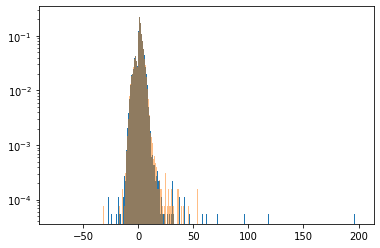

In [129]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [130]:
len(encoded_valid)

6596

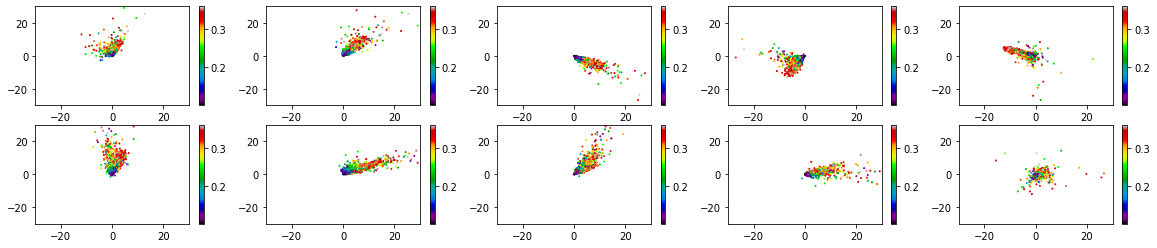

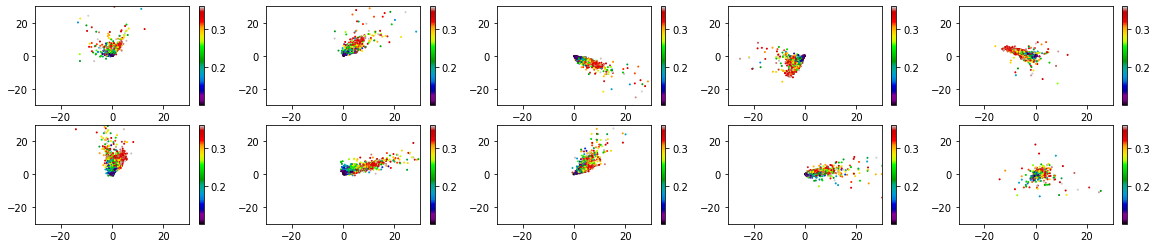

In [137]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['z'][:len(encoded_valid)], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

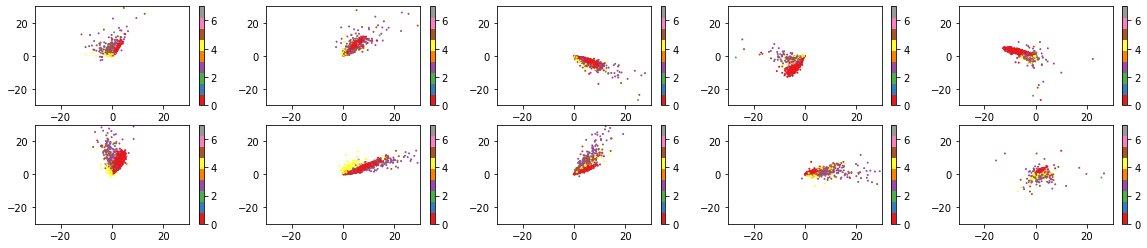

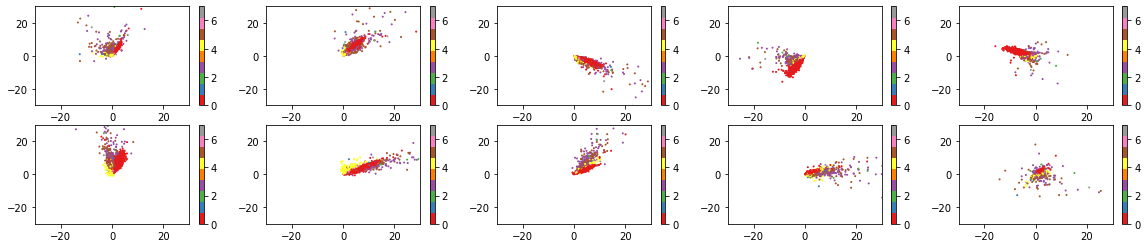

In [139]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['subclass'][:len(encoded_valid)], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [141]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

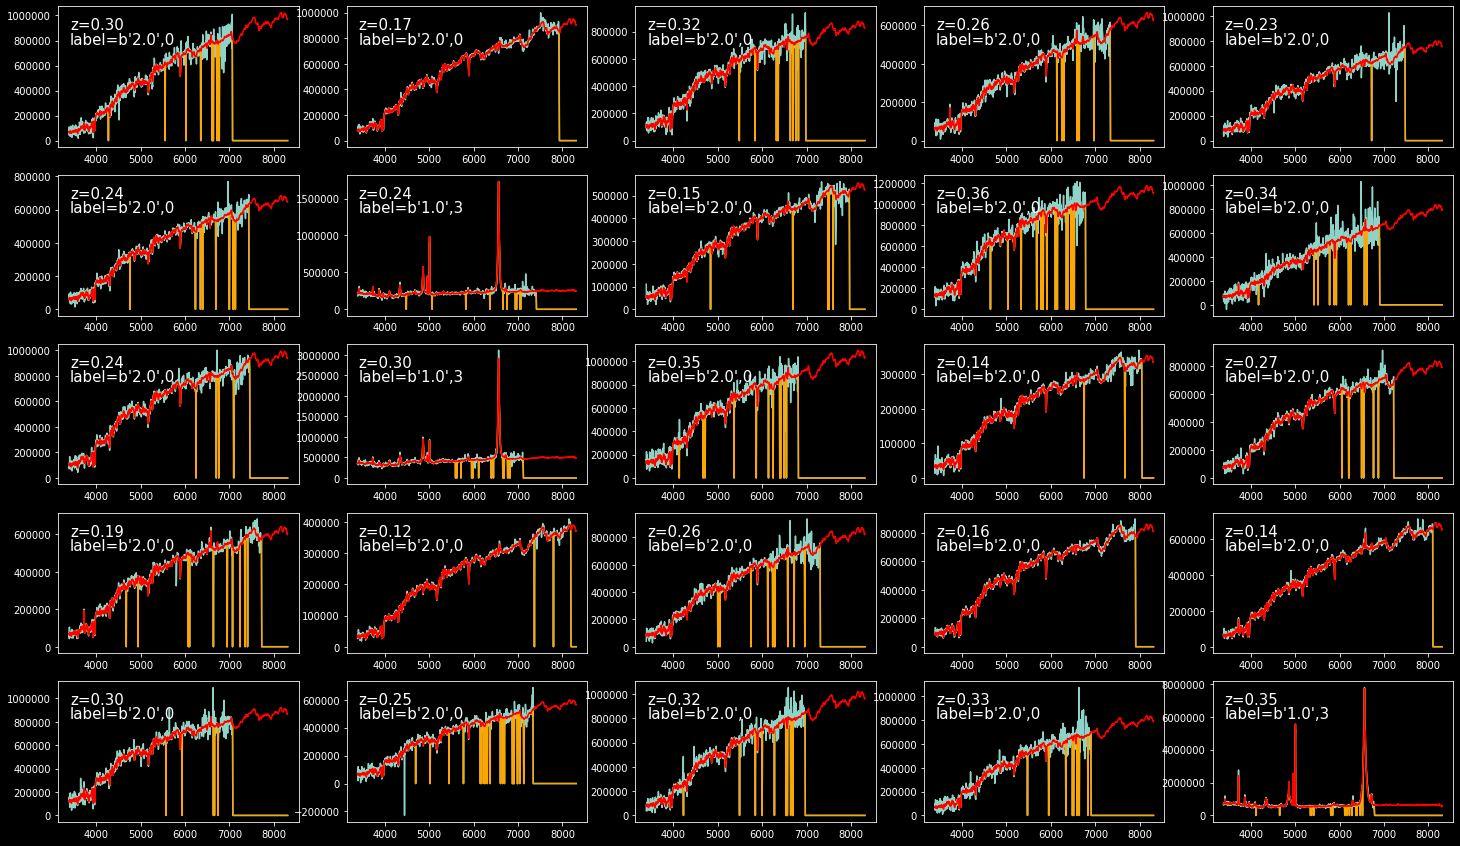

In [142]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec']*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean']), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid['z'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid['class'][ii],valid['subclass'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

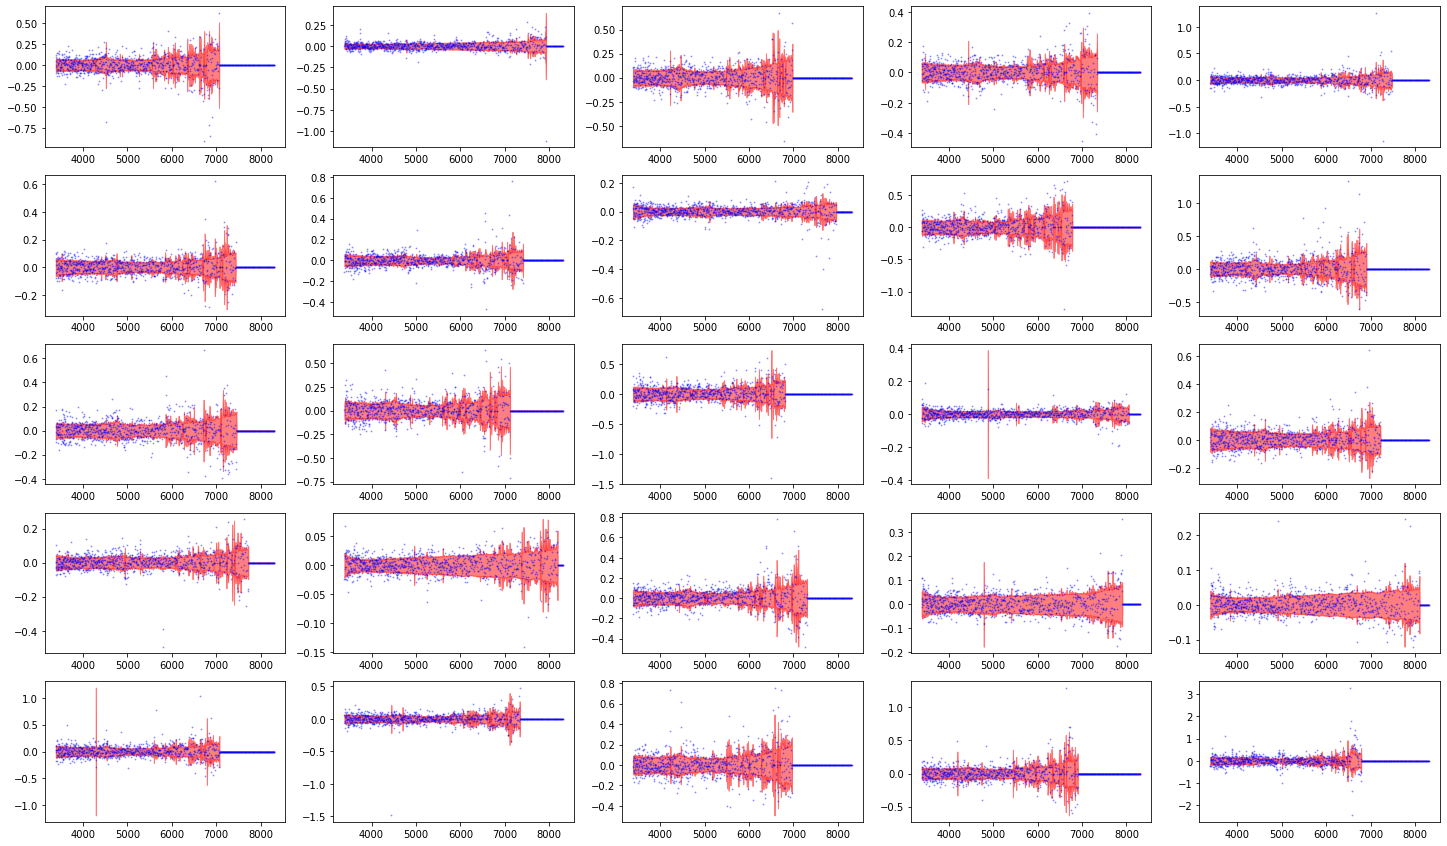

In [177]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [211]:
### Look at reconstruction ability as function of wavelength

In [202]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [203]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

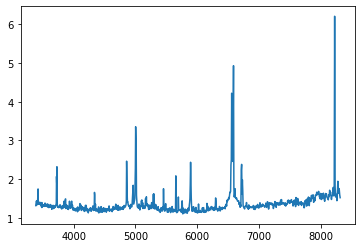

In [204]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0))

In [205]:
np.mean(loss[0]/np.mean(valid['mask'],axis=0))

1.352728079473918

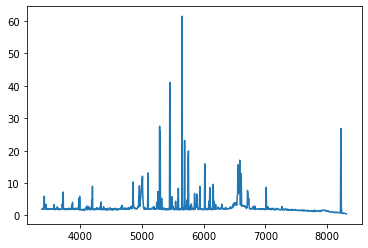

In [206]:
plt.plot(new_wl[:-1],loss[1])